In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from PopSynthesis.Methods.connect_HH_PP.paras_dir import processed_data, output_dir

In [98]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 18}
plt.rc('font', **font)

In [85]:
syn_hh = pd.read_csv(os.path.join(output_dir, "syn_hh_final.csv"))
syn_pp = pd.read_csv(os.path.join(output_dir, "syn_pp_final.csv"))

In [86]:
dict_hhid_POA = dict(zip(syn_hh["hhid"], syn_hh["POA"]))
syn_pp["POA"] = syn_pp.apply(lambda r: dict_hhid_POA[int(r["hhid"])],axis=1)
syn_pp

,age,sex,persinc,nolicence,anywork,hhid,relationship,POA
0,20-29,F,$400-599 p.w.,Some Licence,Y,92723,Child,3012
1,20-29,M,$1500-1999 p.w.,No Licence,N,66408,Child,3006
2,20-29,M,$1500-1999 p.w.,No Licence,N,473616,Child,3051
3,20-29,M,$1500-1999 p.w.,No Licence,N,670750,Child,3073
4,20-29,M,$1500-1999 p.w.,No Licence,N,1179476,Child,3150
...,...,...,...,...,...,...,...,...
7067675,40-49,M,$800-999 p.w.,Some Licence,Y,2801757,Main,3996
7067676,50-59,F,$1000-1249 p.w.,Some Licence,Y,2801758,Main,3996
7067677,20-29,F,$400-599 p.w.,Some Licence,Y,2801759,Main,3996
7067678,50-59,F,$200-299 p.w.,Some Licence,N,2801760,Main,3996


In [87]:
import pickle
with open(os.path.join(processed_data, 'dict_pp_states.pickle', 'rb')) as handle:
    state_names_pp = pickle.load(handle)

In [88]:
state_names_pp

{'age': ['50-59',
  '40-49',
  '10-19',
  '0-9',
  '20-29',
  '60-69',
  '70-79',
  '80-89',
  '30-39',
  '90-99',
  '100+'],
 'sex': ['M', 'F'],
 'persinc': ['$1000-1249 p.w.',
  '$1-199 p.w.',
  'Zero Income',
  '$300-399 p.w.',
  '$800-999 p.w.',
  '$400-599 p.w.',
  '$1250-1499 p.w.',
  '$1500-1999 p.w.',
  '$600-799 p.w.',
  '$2000+ p.w.',
  '$200-299 p.w.',
  'Negative Income',
  'Missing/Refused'],
 'nolicence': ['Some Licence', 'No Licence'],
 'anywork': ['Y', 'N']}

In [89]:
atts_labels = {"age": [
    '0-9', 
    '10-19', 
    '20-29', 
    '30-39', 
    '40-49', 
    '50-59', 
    '60-69',
    '70-79',
    '70-79',
    '80-89',
    '90-99',
    "100+"
],
"persinc": [
    "Missing/Refused",
    "Negative Income",
    "Zero Income",
    '$1-199 p.w.',
    '$200-299 p.w.',
    '$300-399 p.w.',
    '$400-599 p.w.',
    '$600-799 p.w.',
    '$800-999 p.w.',
    '$1000-1249 p.w.',
    '$1250-1499 p.w.',
    '$1500-1999 p.w.',
    '$2000+ p.w.'
]
}

In [90]:
from connecting import process_POA

In [91]:
ls_total_veh = {
"Four or more motor vehicles": "4+", 
"Three motor vehicles": "3", 
"Two motor vehicles": "2", 
"One motor vehicle": "1",
"No motor vehicles": "0"}

In [92]:
df_census_vehs = process_POA()
df_census_vehs["tot_before_none"] = sum([df_census_vehs[x] for x in ls_total_veh])
for x in ls_total_veh:
    df_census_vehs[x] = df_census_vehs[x] + df_census_vehs["None info"] * (df_census_vehs[x])/df_census_vehs["tot_before_none"]
    # df_census_vehs[x] = df_census_vehs.apply(lambda r: int(r[x]), axis=1)
df_census_vehs = df_census_vehs.rename(columns=ls_total_veh).drop(columns=["None info", "tot_before_none"])
df_census_vehs = df_census_vehs.set_index("POA")
df_census_vehs

,0,1,2,3,4+
POA,,,,,
3000,24696.649216,8747.324286,846.361871,84.002208,77.662419
3002,664.575671,1853.443450,792.106184,106.275427,66.599268
3003,1892.991173,2657.208723,541.433281,82.362669,27.004154
3004,1714.772373,5068.042236,1200.623161,138.424788,38.137442
3006,7104.748124,8838.931966,1412.768134,119.800400,46.751376
...,...,...,...,...,...
3990,0.000000,7.125000,21.375000,17.100000,11.400000
3991,13.000000,47.666667,76.555556,40.444444,30.333333
3992,4.987654,180.802469,261.851852,105.987654,52.370370


In [93]:
syn_check_vehs = syn_hh.groupby("totalvehs")["POA"].value_counts()
syn_check_vehs

totalvehs  POA 
0          3000    16203
           3006     5163
           3141     3953
           3053     3544
           3008     3276
                   ...  
4+         3889        4
           3506        4
           3576        4
           3964        4
           3893        3
Name: count, Length: 3421, dtype: int64

In [94]:
to_plot = {}
for val in df_census_vehs.columns:
    to_plot[val] = [[], []]
    for poa in df_census_vehs.index:
        to_plot[val][0].append(df_census_vehs.loc[poa][val])
        if (val, int(poa)) in syn_check_vehs.index:
            to_plot[val][1].append(syn_check_vehs[(val, int(poa))])
        else:
            to_plot[val][1].append(0)
to_plot

{'0': [[24696.649215623132,
   664.5756712774613,
   1892.991173416407,
   1714.7723732040852,
   7104.748124062031,
   4416.853263019117,
   2375.5019157088122,
   1339.9267732363357,
   646.7805725632963,
   443.77033492822966,
   610.4518979057592,
   518.9744604316547,
   511.5826911677534,
   1818.1201201201202,
   1869.0756759820872,
   120.60904255319149,
   821.5757171447632,
   401.83778313253015,
   548.7601547388781,
   76.30416312659304,
   91.58878504672897,
   721.4179090122151,
   1366.50081496326,
   1911.6925542727581,
   1841.4450867052024,
   1512.3851975051975,
   298.4253000923361,
   329.0193345323741,
   107.56845097110374,
   545.9408980427274,
   352.2670737222976,
   1257.9559426229507,
   999.3767228177642,
   302.5300146412884,
   445.32419403434767,
   413.3151408450704,
   932.9684850718761,
   0.0,
   1490.3395692032495,
   981.3289658399626,
   406.1218568665377,
   172.92157985117345,
   2916.3813049514115,
   525.3098656785548,
   5068.135052890885,
  

findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.


findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not

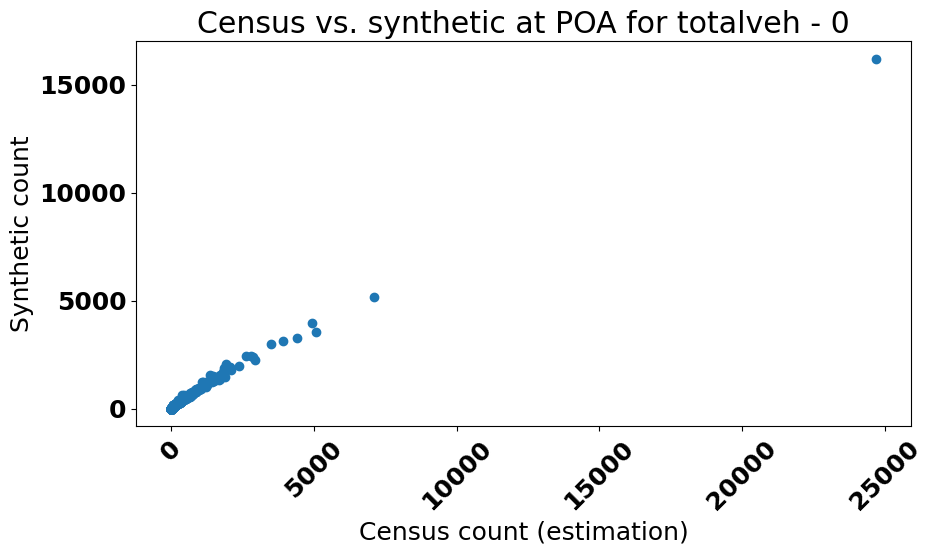

findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not

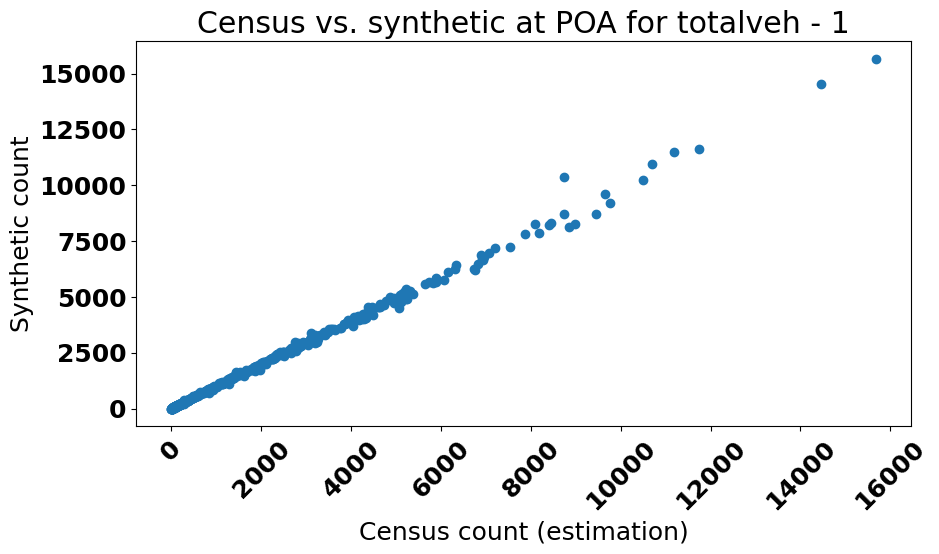

findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not

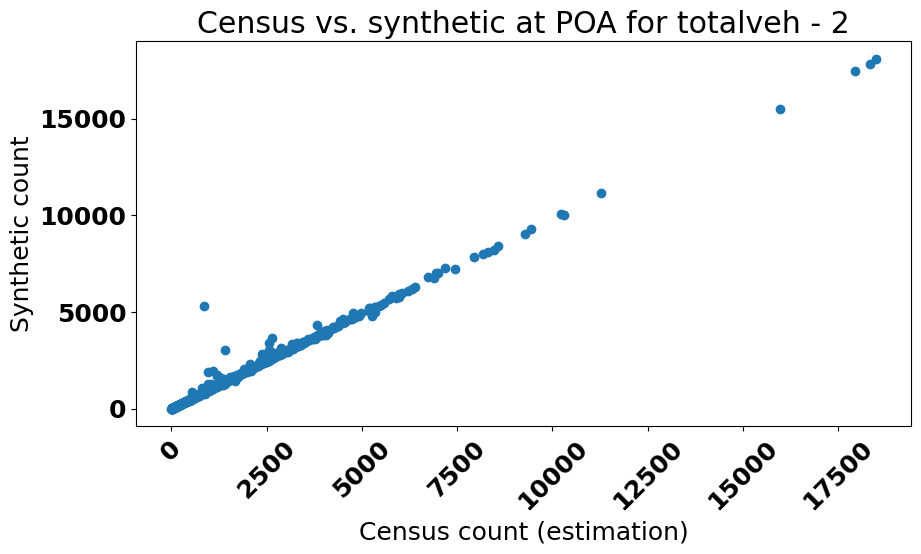

findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not

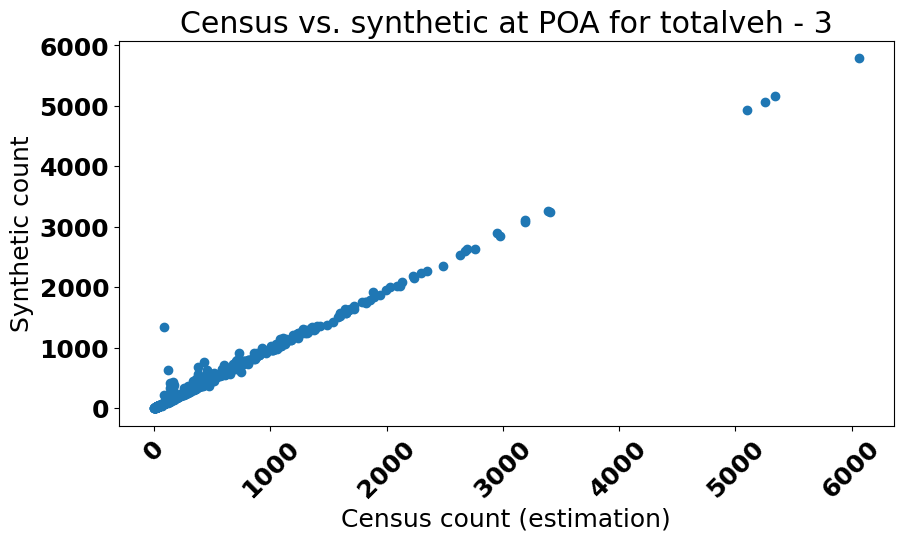

findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not

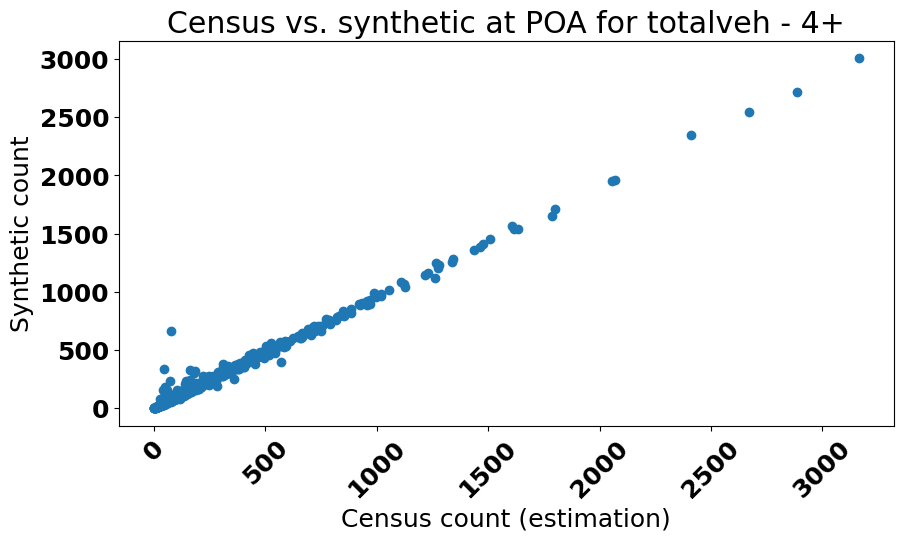

In [99]:
for val in df_census_vehs.columns:
    x = to_plot[val][0],
    y = to_plot[val][1]
    fig = plt.figure(figsize = (10, 5))
    plt.scatter(x=x, y=y)
    plt.xlabel(f"Census count (estimation)")
    plt.ylabel("Synthetic count")
    plt.title(f"Census vs. synthetic at POA for totalveh - {val}")
    plt.xticks(rotation=45)
    plt.show()

In [100]:
def plot_bar_syn_rela(rela, att):
    df = syn_pp[syn_pp["relationship"] == rela]
    n_syn = len(df) 
    counts = df[att].value_counts()
    data_syn = []
    data_sample = []
    if rela != "Main":
        df_rela_sample = pd.read_csv(os.path.join(processed_data, f"connect_main_{rela}.csv"))
        sub_df_sample = df_rela_sample.groupby(f"{att}_{rela}")["_weight"].sum() 
    else:
        df_rela_sample = pd.read_csv(os.path.join(processed_data, f"connect_hh_main.csv"))
        sub_df_sample = df_rela_sample.groupby(att)["_weight"].sum()
    n_sample = df_rela_sample["_weight"].sum()
    sub_df_sample = sub_df_sample / n_sample
    for state in atts_labels[att]:
        if state in counts.index:
            data_syn.append((counts.at[state]/n_syn)*100) 
        else:
            data_syn.append(0) 
        if state in sub_df_sample.index:
            data_sample.append((sub_df_sample[state])*100)
        else:
            data_sample.append(0)
    X = atts_labels[att]
    X_axis = np.arange(len(X))
    fig = plt.figure(figsize = (10, 5))
    # creating the bar plot
    plt.bar(X_axis - 0.2, data_syn, 0.4, label = 'Synthetic') 
    plt.bar(X_axis + 0.2, data_sample, 0.4, label = 'VISTA') 
    plt.xlabel(f"{att} groups")
    plt.ylabel(f"Percentage in the {rela} population")
    plt.title(f"Total number people for each {att} groups for {rela}")
    plt.xticks(X_axis, X, rotation=45)
    plt.legend() 
    plt.show()

findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not

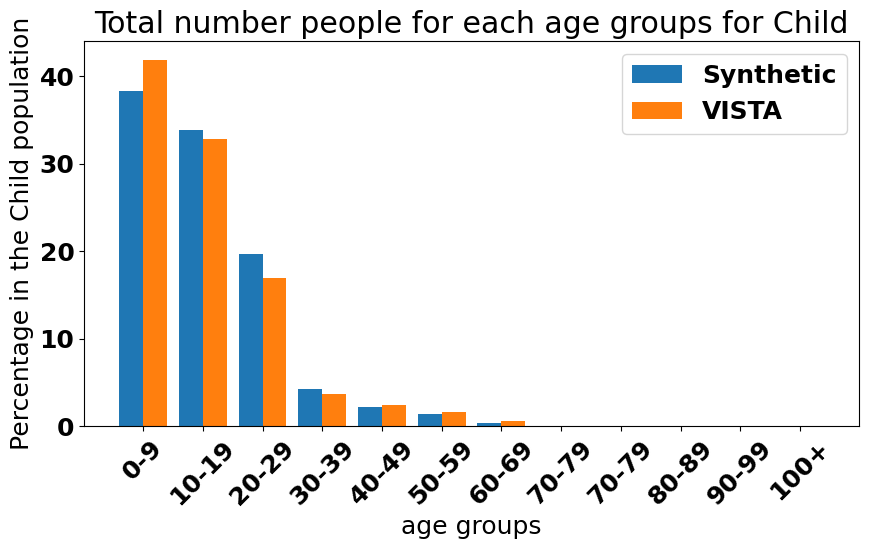

findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not

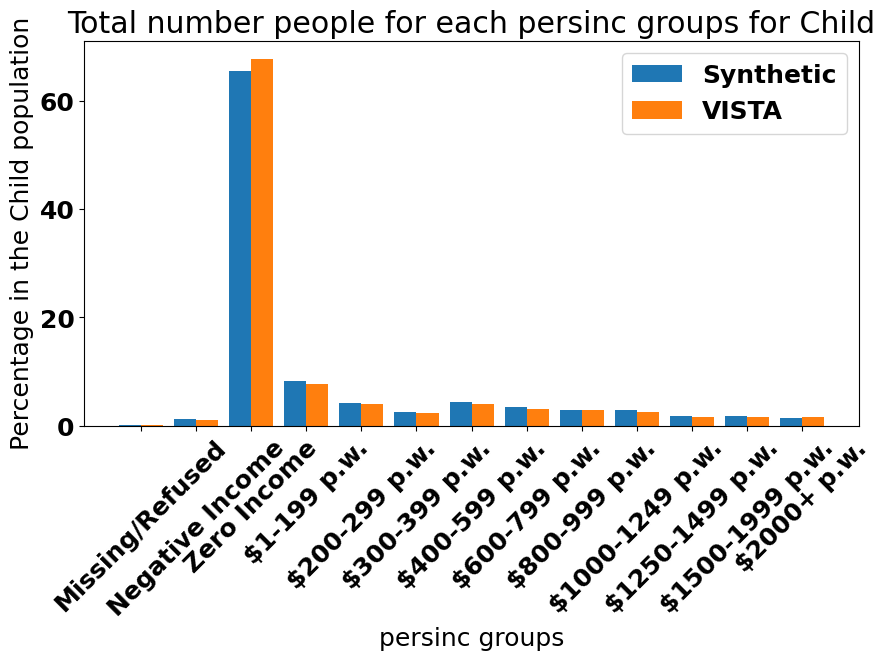

findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not

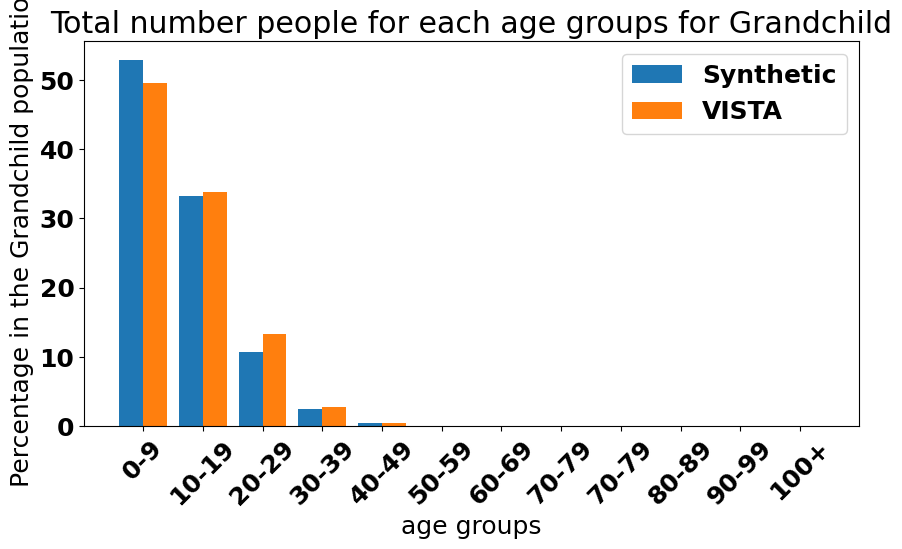

findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not

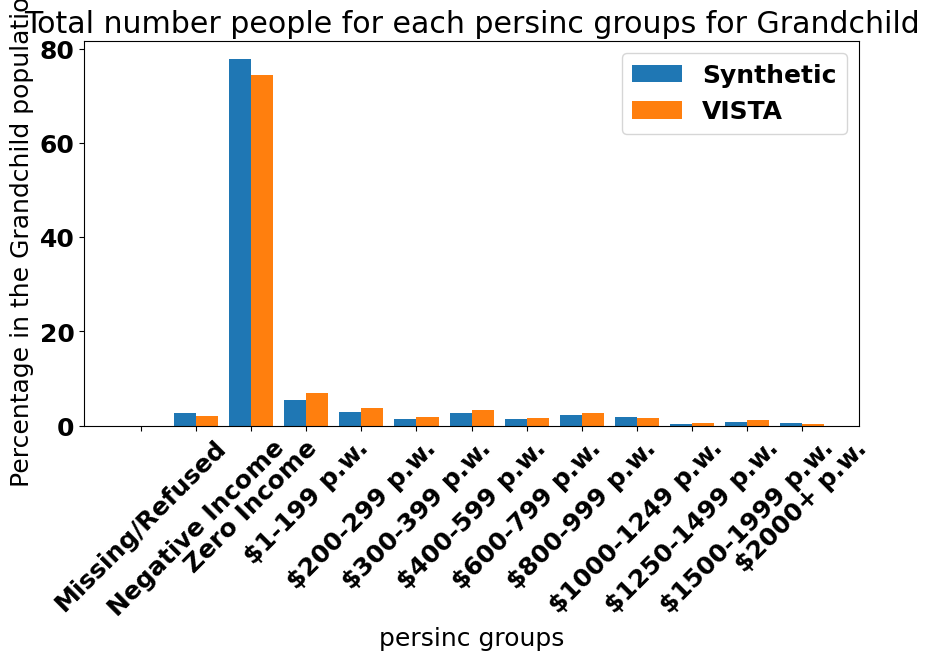

findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not

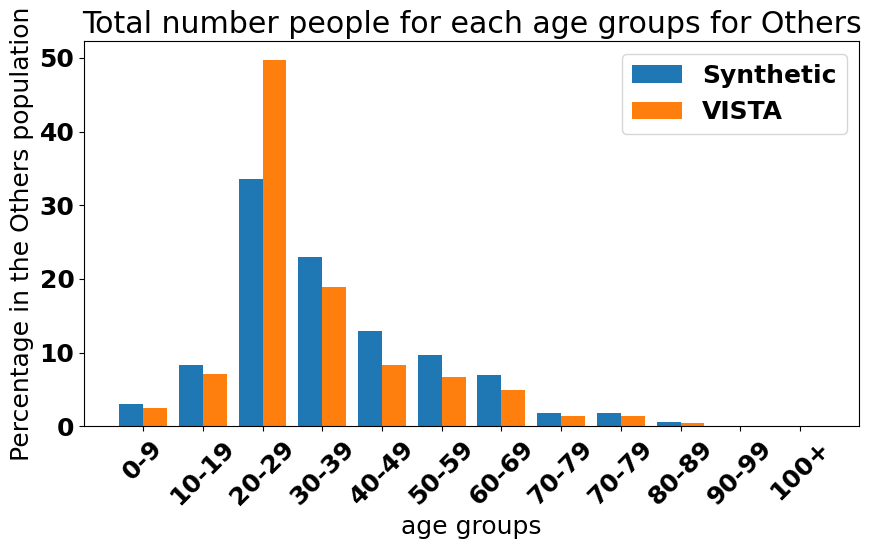

findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not

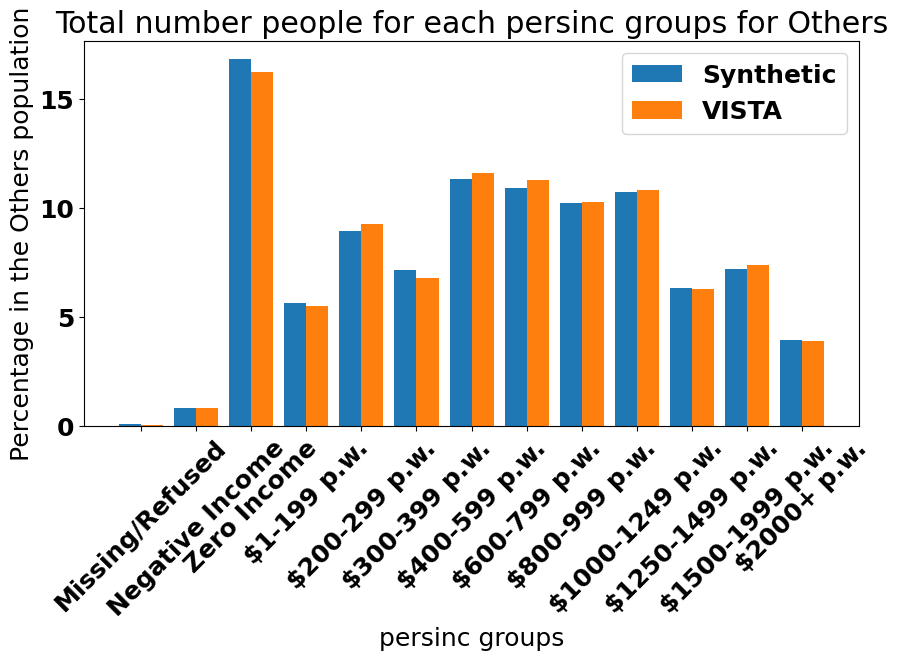

findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not

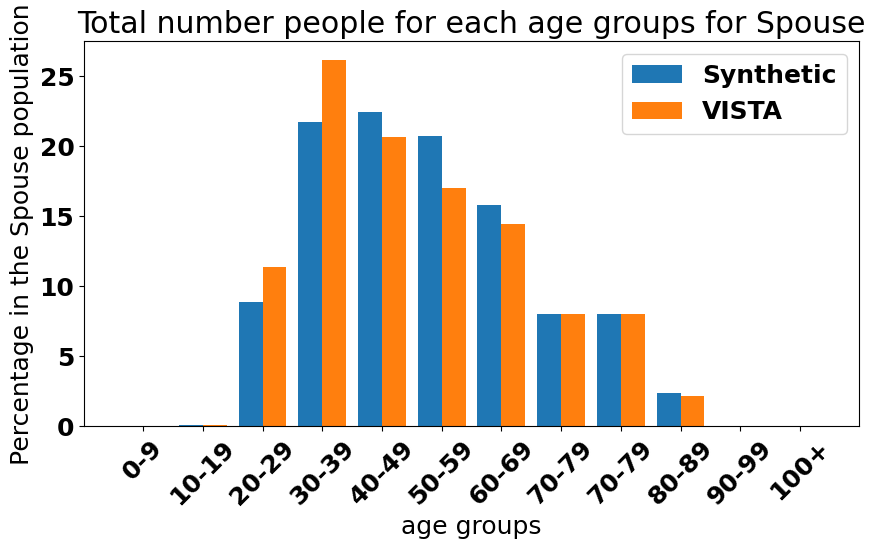

findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not

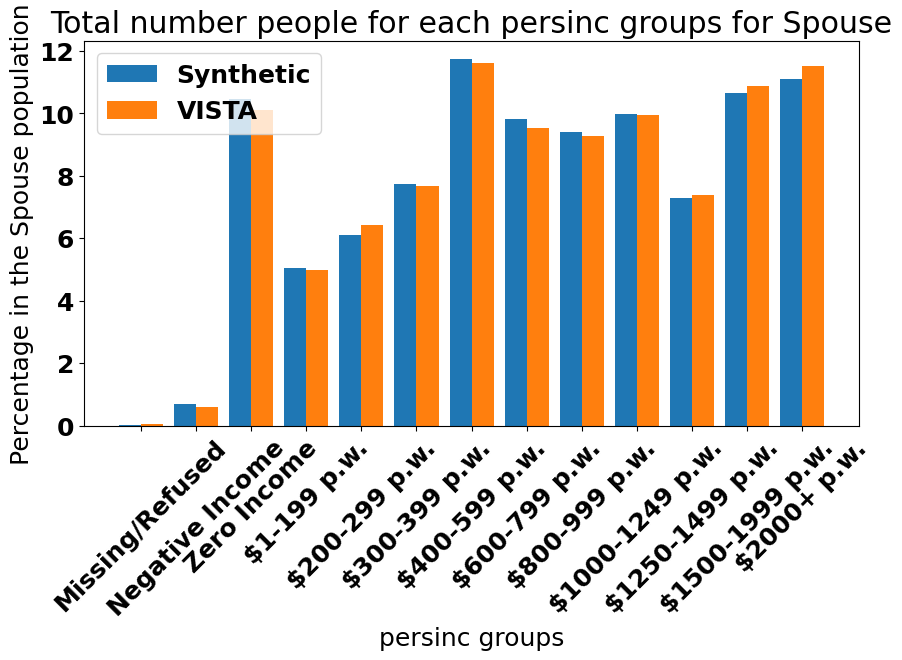

findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not

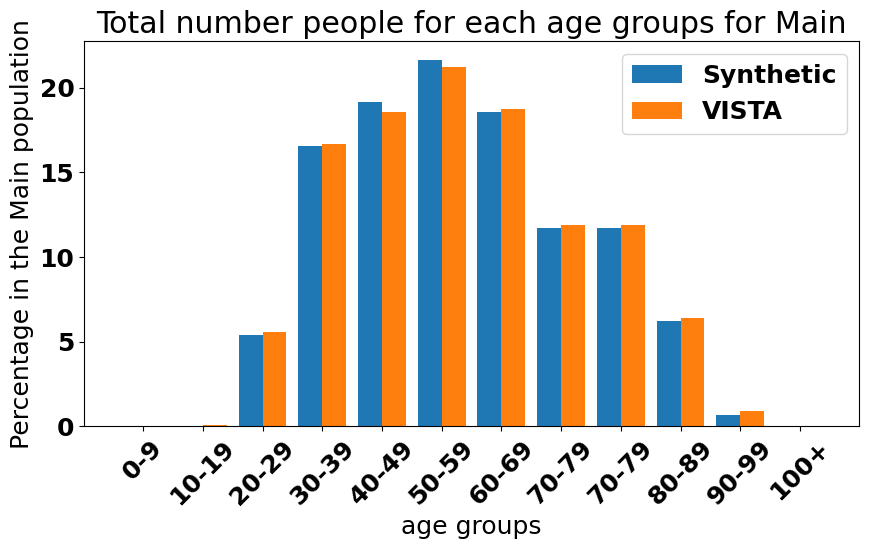

findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not

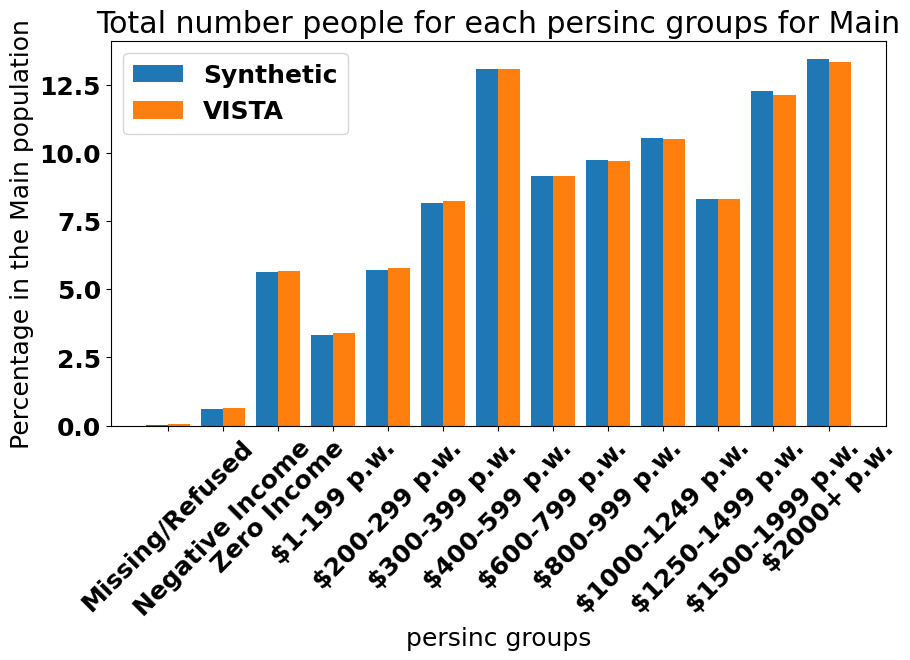

In [101]:
ls_rela = syn_pp["relationship"].unique()
for rela in ls_rela:
    plot_bar_syn_rela(att="age", rela=rela)
    plot_bar_syn_rela(att="persinc", rela=rela)